In [1]:
import matplotlib.pyplot as plt
from tifffile import imread
import numpy as np
from ipywidgets import interact

title1 = 'Normal'
title2 = 'Fibrotic'
title3 = 'Emphysematic'


tiff1 = np.array(imread('%s.tiff' % title1))
tiff2 = np.array(imread('%s.tiff' % title2))
tiff3 = np.array(imread('%s.tiff' % title3))

In [2]:
print(np.max(tiff3))
tiff1 = 2 - tiff1
tiff2 = 2 - tiff2
tiff3 = 2 - tiff3

2


In [3]:
# Compute center slice index
center_z1 = tiff1.shape[0] // 2
center_z2 = tiff2.shape[0] // 2
center_z3 = tiff3.shape[0] // 2

In [4]:
# Define a function to display a slice
def display_slice(slice_number):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(tiff1[slice_number, :, :], cmap='gray')
    axes[0].set_title(title1)

    axes[1].imshow(tiff2[slice_number, :, :], cmap='gray')
    axes[1].set_title(title2)

    axes[2].imshow(tiff3[slice_number, :, :], cmap='gray')
    axes[2].set_title(title3)

    for ax in axes:
        ax.axis('off')
    plt.show()

# Get the minimum number of slices across all segmentations
min_slices = min(tiff1.shape[0], tiff2.shape[0], tiff3.shape[0])

# Create an interactive widget to select the slice
interact(display_slice, slice_number=(0, min_slices-1))

interactive(children=(IntSlider(value=13, description='slice_number', max=27), Output()), _dom_classes=('widge…

<function __main__.display_slice(slice_number)>

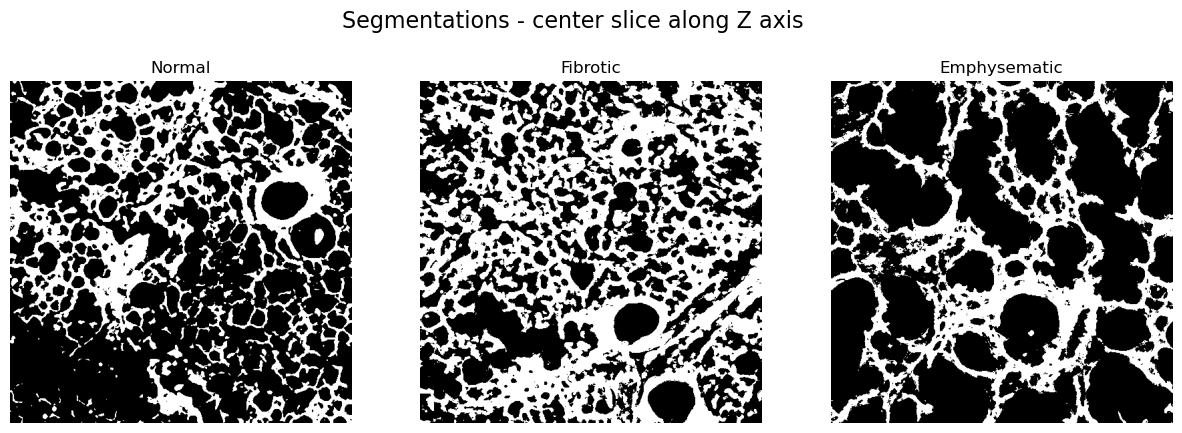

In [5]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(tiff1[center_z1], cmap='gray')
axes[0].set_title(title1)

axes[1].imshow(tiff2[center_z2], cmap='gray')
axes[1].set_title(title2)

axes[2].imshow(tiff3[center_z3], cmap='gray')
axes[2].set_title(title3)

for ax in axes:
    ax.axis('off')

fig.suptitle("Segmentations - center slice along Z axis", fontsize=16)
plt.savefig('plot_segmentations_center_slice.png')
plt.show()

In [24]:
from tifffile import imwrite
imwrite("%s_segmentation_center_slice.png" % title1, tiff1[center_z1]*255)
imwrite("%s_segmentation_center_slice.png" % title2, tiff2[center_z2]*255)
imwrite("%s_segmentation_center_slice.png" % title3, tiff3[center_z3]*255)

In [6]:
def create_mesh_and_save(data, file_name, rotate_x=0, rotate_y=0, rotate_z=0):
    import numpy as np
    from stl import mesh
    import vtk

    from vtkplotlib.image_io import vtkimagedata_from_array

    image3D = vtk.vtkImageAppend()
    image3D.SetAppendAxis(2)
    data = data.astype(np.uint8)
    for i in range(data.shape[2]):
        image_data = vtkimagedata_from_array(data[:,:,i])
        image3D.AddInputData(image_data)
    image3D.Update()

    discrete = vtk.vtkFlyingEdges3D()
    discrete.SetInputData(image3D.GetOutput())
    discrete.GenerateValues(1, 1, 1)
    discrete.Update()

    smoothing_iterations = 10
    pass_band = 0.001
    feature_angle = 120.0

    smoother = vtk.vtkWindowedSincPolyDataFilter()
    smoother.SetInputConnection(discrete.GetOutputPort())
    smoother.SetNumberOfIterations(smoothing_iterations)
    smoother.BoundarySmoothingOn()
    smoother.FeatureEdgeSmoothingOn()
    smoother.SetFeatureAngle(feature_angle)
    smoother.SetPassBand(pass_band)
    smoother.NonManifoldSmoothingOn()
    smoother.NormalizeCoordinatesOn()
    smoother.Update()

    decimate = vtk.vtkDecimatePro()
    decimate.SetInputData(smoother.GetOutput())
    decimate.SetTargetReduction(0.5)
    decimate.PreserveTopologyOn()
    decimate.Update()
    
    transform = vtk.vtkTransform()
    transform.RotateX(rotate_x)
    transform.RotateY(rotate_y)
    transform.RotateZ(rotate_z)
    
    transformFilter = vtk.vtkTransformPolyDataFilter()
    transformFilter.SetTransform(transform)
    transformFilter.SetInputData(decimate.GetOutput())
    transformFilter.Update()
    
    final_mesh = transformFilter.GetOutput()

    writer = vtk.vtkSTLWriter()
    writer.SetInputData(final_mesh)
    writer.SetFileTypeToBinary()
    writer.SetFileName(file_name)
    writer.Write()
    return final_mesh, mesh.Mesh.from_file(file_name)
    
mesh1_vtk, mesh1 = create_mesh_and_save(tiff1, "%s.stl" % title1, rotate_x=90)
mesh2_vtk, mesh2 = create_mesh_and_save(tiff2, "%s.stl" % title2, rotate_x=90)
mesh3_vtk, mesh3 = create_mesh_and_save(tiff3, "%s.stl" % title3, rotate_x=90)

In [7]:
import vtkplotlib as vpl

def screenshot_mesh(mesh, title, color=[255, 255, 255, 255]):
    vpl.mesh_plot(mesh, color=color)
    vpl.save_fig("%s_mesh.png" % title, off_screen=True, pixels=(2000, 2000), trim_pad_width=1)
    vpl.close()

screenshot_mesh(mesh1, title1)
screenshot_mesh(mesh2, title2)
screenshot_mesh(mesh3, title3)

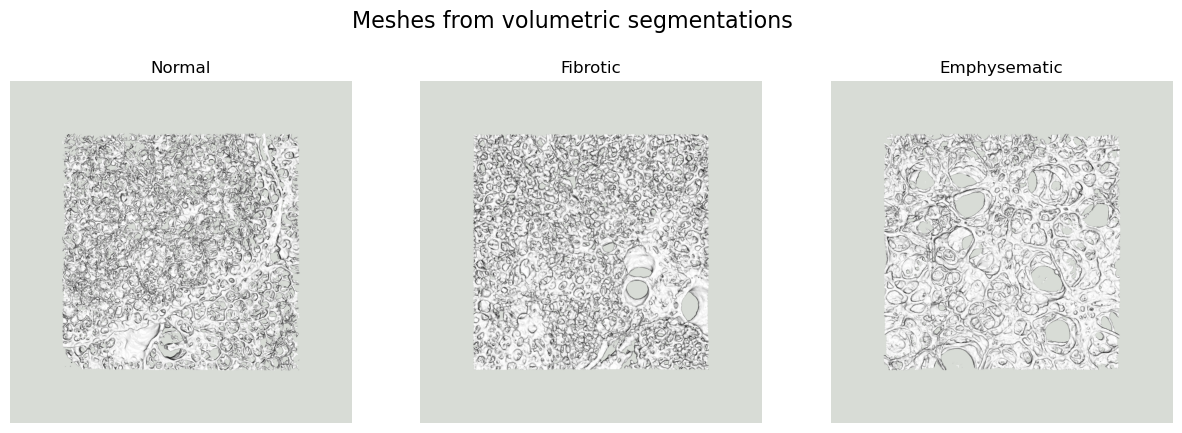

In [8]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Read the images back in
img1 = imread("%s_mesh.png" % title1)
img2 = imread("%s_mesh.png" % title2)
img3 = imread("%s_mesh.png" % title3)

# Display the images in a matplotlib grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img1)
axes[0].set_title(title1)

axes[1].imshow(img2)
axes[1].set_title(title2)

axes[2].imshow(img3)
axes[2].set_title(title3)

for ax in axes:
    ax.axis('off')

fig.suptitle("Meshes from volumetric segmentations", fontsize=16)
plt.savefig('plot_meshes_from_segmentations.png')
plt.show()

In [9]:
import numpy as np

def calc_min_dist(image_3d):
    # Initialize distance arrays with max distances
    dist_up = np.full(image_3d.shape, image_3d.shape[0], dtype=np.int32)
    dist_down = np.full(image_3d.shape, image_3d.shape[0], dtype=np.int32)

    for x in range(image_3d.shape[1]):
        for y in range(image_3d.shape[2]):
            # Get z-coordinates of foreground pixels at this x, y position
            z_coords = np.where(image_3d[:, x, y] == 1)[0]

            if len(z_coords) > 0:
                for z in range(image_3d.shape[0]):
                    # Calculate distances to nearest foreground pixel in both directions
                    dist_up[z, x, y] = np.abs(z - z_coords[z_coords <= z]).min() if len(z_coords[z_coords <= z]) > 0 else image_3d.shape[0]
                    dist_down[z, x, y] = np.abs(z - z_coords[z_coords >= z]).min() if len(z_coords[z_coords >= z]) > 0 else image_3d.shape[0]

    return dist_up, dist_down


# Compute distance maps
dist_up1, dist_down1 = calc_min_dist(tiff1)
dist_up2, dist_down2 = calc_min_dist(tiff2)
dist_up3, dist_down3 = calc_min_dist(tiff3)


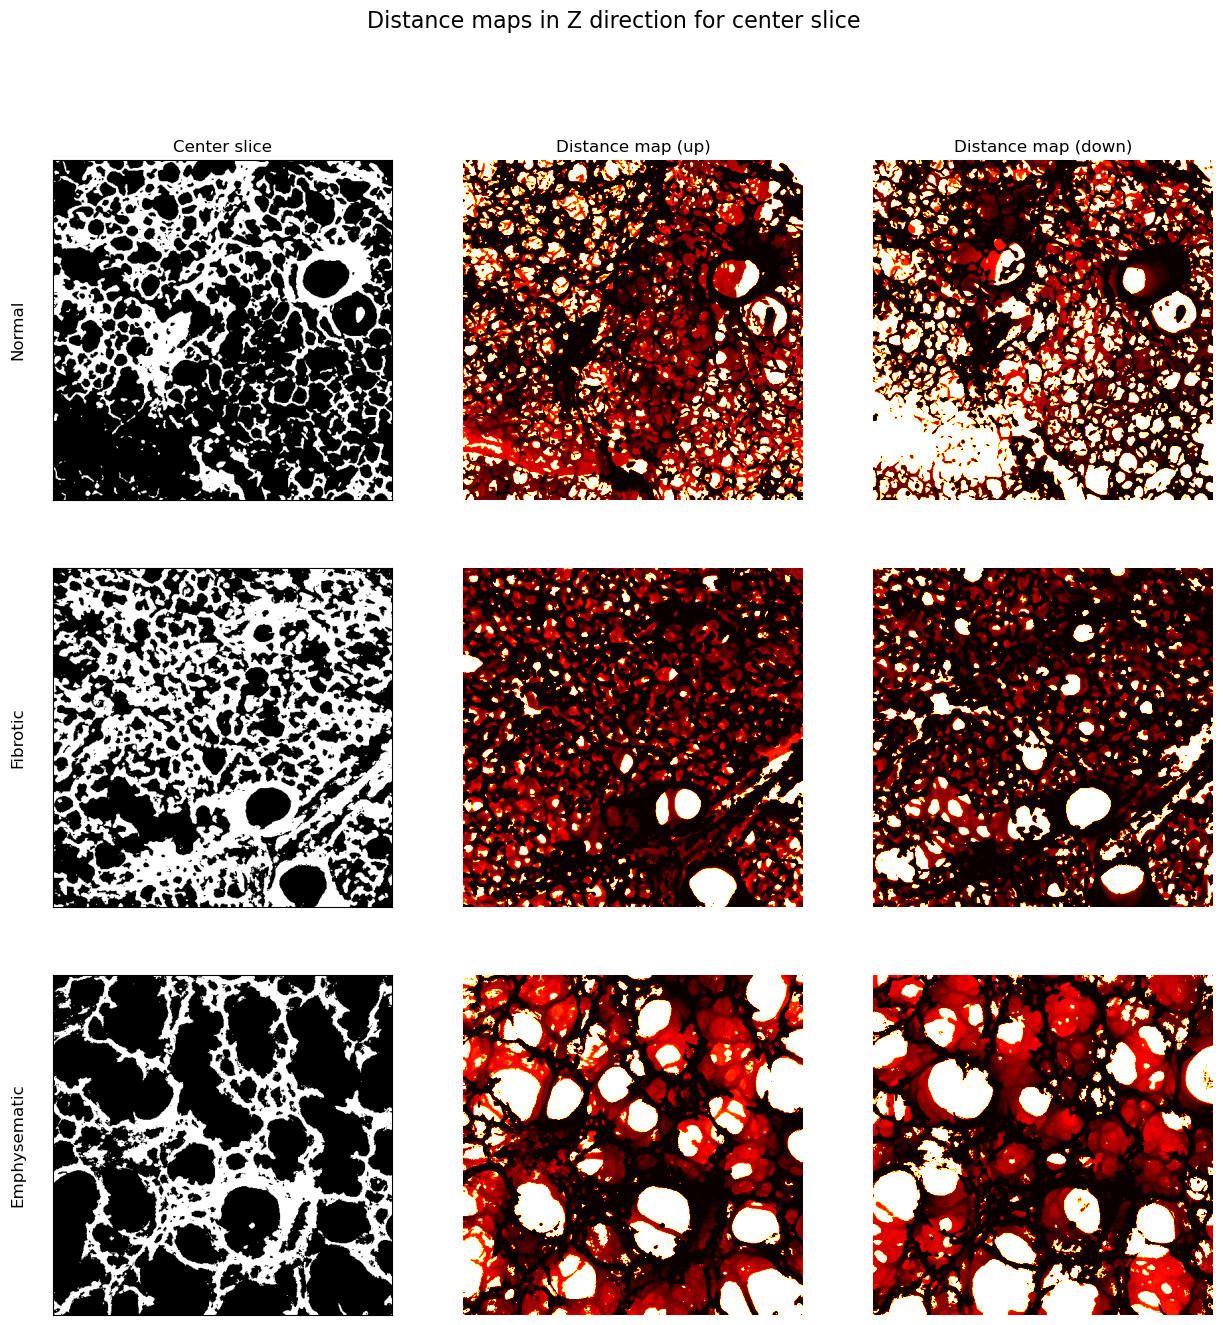

In [10]:
dist_up1_masked = np.where(dist_up1 == -1, np.nan, dist_up1)
dist_up2_masked = np.where(dist_up2 == -1, np.nan, dist_up2)
dist_up3_masked = np.where(dist_up3 == -1, np.nan, dist_up3)
dist_down1_masked = np.where(dist_down1 == -1, np.nan, dist_down1)
dist_down2_masked = np.where(dist_down2 == -1, np.nan, dist_down2)
dist_down3_masked = np.where(dist_down3 == -1, np.nan, dist_down3)

# Plot center slices and their distance maps
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Volume 1
axs[0, 0].imshow(tiff1[center_z1], cmap='gray')
axs[0, 1].imshow(dist_up1_masked[center_z1], cmap='hot')
axs[0, 2].imshow(dist_down1_masked[center_z1], cmap='hot')

# Volume 2
axs[1, 0].imshow(tiff2[center_z2], cmap='gray')
axs[1, 1].imshow(dist_up2_masked[center_z2], cmap='hot')
axs[1, 2].imshow(dist_down2_masked[center_z2], cmap='hot')

# Volume 3
axs[2, 0].imshow(tiff3[center_z3], cmap='gray')
axs[2, 1].imshow(dist_up3_masked[center_z3], cmap='hot')
axs[2, 2].imshow(dist_down3_masked[center_z3], cmap='hot')

# Set column titles
axs[0, 0].set_title('Center slice')
axs[0, 1].set_title('Distance map (up)')
axs[0, 2].set_title('Distance map (down)')

# Set row titles
for i, label in enumerate([title1, title2, title3]):
#     axs[i, 0].axis('off')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_ylabel(label, rotation=90, size='large', labelpad=20)


# Turn off the axes for all subplots
for ax in axs[:, 1:].flat:
    ax.axis('off')

fig.suptitle("Distance maps in Z direction for center slice", fontsize=16)

# plt.subplots_adjust(wspace=0.2, hspace=0.2)
# plt.tight_layout()

plt.savefig('plot_distance_maps_for_center_slice.png')
plt.show()

In [34]:
from tifffile import imwrite
imwrite("%s_distance_map_center_slice_up.tif" % title1, dist_up1[center_z1])
imwrite("%s_distance_map_center_slice_down.tif" % title1, dist_down1[center_z1])
imwrite("%s_distance_map_center_slice_up.tif" % title2, dist_up2[center_z2])
imwrite("%s_distance_map_center_slice_down.tif" % title2, dist_down2[center_z2])
imwrite("%s_distance_map_center_slice_up.tif" % title3, dist_up3[center_z3])
imwrite("%s_distance_map_center_slice_down.tif" % title3, dist_down3[center_z3])

In [11]:
def reconstruct_volume(dist_up_image, dist_down_image, slice_index):
    height, width = dist_up_image.shape

    # Calculate the total depth from the two images
    depth = np.max(dist_up_image + dist_down_image) + 1

    # Initialize the volume with zeros
    volume = np.zeros((depth, height, width), dtype=int)

    # Iterate over the pixels in the images
    for y in range(height):
        for x in range(width):
            # Calculate the z-coordinates of the '1's in the volume
            start_z = max(0, slice_index - dist_up_image[y, x])
            end_z = min(depth, slice_index + dist_down_image[y, x] + 1)

            # Set the corresponding pixels in the volume to '1'
            volume[start_z:end_z, y, x] = 1

    return volume

reconstructed1 = reconstruct_volume(dist_up1[center_z1], dist_down1[center_z1], center_z1)
reconstructed2 = reconstruct_volume(dist_up2[center_z2], dist_down2[center_z2], center_z2)
reconstructed3 = reconstruct_volume(dist_up3[center_z3], dist_down3[center_z3], center_z3)

In [12]:
from tifffile import imwrite
imwrite("%s_reconstructed.tif" % title1, reconstructed1)
imwrite("%s_reconstructed.tif" % title2, reconstructed2)
imwrite("%s_reconstructed.tif" % title3, reconstructed3)

In [18]:
reconstructed_mesh1_vtk, reconstructed_mesh1 = create_mesh_and_save(reconstructed1, "%s_reconstructed.stl" % title1, rotate_x=65, rotate_z=30)
reconstructed_mesh2_vtk, reconstructed_mesh2 = create_mesh_and_save(reconstructed2, "%s_reconstructed.stl" % title2, rotate_x=65, rotate_z=30)
reconstructed_mesh3_vtk, reconstructed_mesh3 = create_mesh_and_save(reconstructed3, "%s_reconstructed.stl" % title3, rotate_x=65, rotate_z=30)

In [19]:
screenshot_mesh(reconstructed_mesh1, "%s_reconstructed" % title1)
screenshot_mesh(reconstructed_mesh2, "%s_reconstructed" % title2)
screenshot_mesh(reconstructed_mesh3, "%s_reconstructed" % title3)

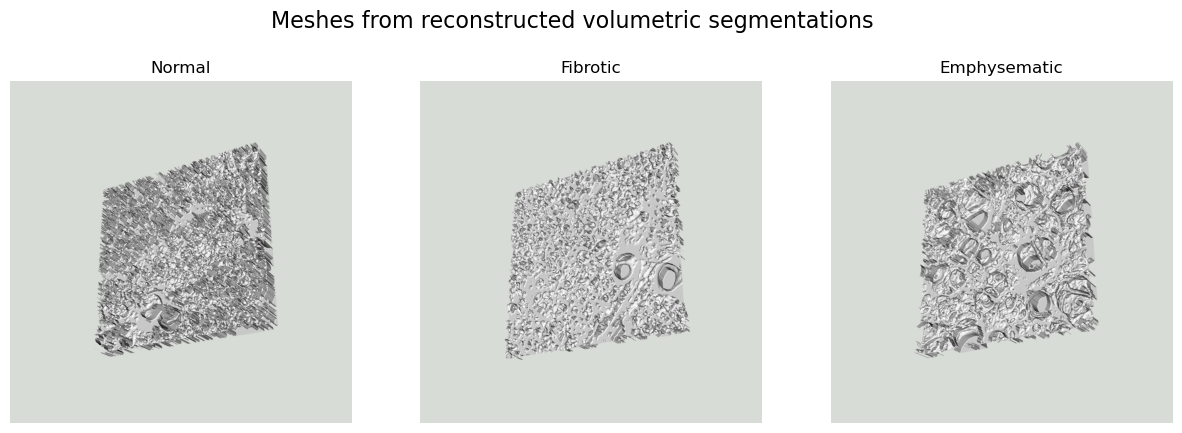

In [20]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Read the images back in
img_reconstructed1 = imread("%s_reconstructed_mesh.png" % title1)
img_reconstructed2 = imread("%s_reconstructed_mesh.png" % title2)
img_reconstructed3 = imread("%s_reconstructed_mesh.png" % title3)

# Display the images in a matplotlib grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_reconstructed1)
axes[0].set_title(title1)

axes[1].imshow(img_reconstructed2)
axes[1].set_title(title2)

axes[2].imshow(img_reconstructed3)
axes[2].set_title(title3)

for ax in axes:
    ax.axis('off')
fig.suptitle("Meshes from reconstructed volumetric segmentations", fontsize=16)
plt.savefig('plot_meshes_from_reconstructed_segmentations.png')
plt.show()

In [35]:
vpl.mesh_plot(mesh1)
vpl.show()